In [ ]:
#|default_exp data

In [ ]:
#|hide 
%load_ext autoreload
%autoreload 2

In [ ]:
#|hide 
import os 
import matplotlib.pyplot as plt 

In [ ]:
#|hide 
os.chdir('/home/frank/Work/Projecten/DoRe/data/maxrf/crono')

# Download demo data 

> Getting started 

Because we like to study historic inks in our lab, my colleague Birgit Reissland prepared an artificially aged *blind test* sample with inks on paper. A detail (see image below) with iron-gall ink was scanned with the Crono MA-XRF instrument and saved with the awkward file name starting with the hour time stamp 14:20:02 by the Crono software: 

    '14200215102021-blindTest2AgedDetail.HDF5' (50.6Mb).

In this tutorial we will explore and process the contents of this Crono HDF5 file. 

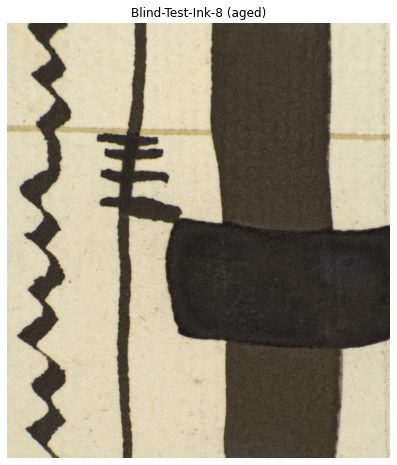

In [ ]:
#|echo: false

img_vis = plt.imread('Ink-08-aged-VIS.png')[100:1200, 50:1300] # roughly the scanning area
img_vis = img_vis.transpose([1, 0, 2])[:,::-1] # rotate 90 deg clockwise 

h, w, _ = img_vis.shape

fig, ax = plt.subplots(figsize=[8, 8])
#ax.imshow(FeKa_map, extent=[0, w, h, 0], origin='lower')
ax.imshow(img_vis)
ax.set_title('Blind-Test-Ink-8 (aged)')
ax.axis('off');

If you want to try using the `cronomaxrf` package, you can download this small demo dataset from my [Backblaze](https://www.backblaze.com/) cloud storage by running the code below. Alternatively, you can manually download the HDF5 and image file by clicking on the links here: [Crono HDF5](https://f002.backblazeb2.com/file/crono-maxrf-data-demo/14200215102021-blindTest2AgedDetail.HDF5) and [png image](https://f002.backblazeb2.com/file/crono-maxrf-data-demo/Ink-08-aged-VIS.png).

In [ ]:
from cronomaxrf.data import download 

In [ ]:
download()

Checking your current working directory: 
'/mnt/datadisk/Work/Projecten/DoRe/data/maxrf/crono'

Please wait while synchronizing 2 files...
(1) '14200215102021-blindTest2AgedDetail.HDF5
(2) 'Ink-08-aged-VIS.png
Ready!


*Also included in the demo dataset is (2) a photo of the scan area.* 

# API 

In [ ]:
#| export 

import wget 
import re 
import os 
import sys
import ssl 
import filehash 

def _bar_progress(current, total, width=80):
    '''Create this bar_progress method which is invoked automatically from wget'''

    percent = (100 * current) // total 
    progress_message = f'Downloading {total//1e6} MB: {percent}% '
    # Don't use print() as it will print in new line every time.
    sys.stdout.write("\r" + progress_message)
    sys.stdout.flush()

def download():
    '''Download demo files from cloud storage. '''
    
    # trying to fix SSL errors with wget.download()  below 
    ssl._create_default_https_context = ssl._create_unverified_context
    
    cwd = os.getcwd()

    bucket_url = 'https://f002.backblazeb2.com/file/crono-maxrf-data-demo/'

    fname_list = ['14200215102021-blindTest2AgedDetail.HDF5', 
                  'Ink-08-aged-VIS.png'] 
    
    #sha1 file hashes 
    fhash_list = ['386bff97bed28d0302bf93abd00d591c4f45b44d', 
                 '7d8c7f1c5f105f10c0ec06fdb9440cf3ea9c00aa']

    n_files = len(fname_list)


    print(f'Checking your current working directory: \n\'{cwd}\'\n')
    print(f'Please wait while synchronizing {n_files} files...')

    for i, [fname, fhash] in enumerate(zip(fname_list, fhash_list)):

        # do not download again if already present  
        if fname in os.listdir():        
            print(f'({i+1}) \'{fname}') 

        # download    
        else: 
            url = bucket_url + fname 
            fname = wget.download(url, bar=_bar_progress)
            is_ok = _check_filehash(fname, fhash)
            if is_ok: 
                print(f' ({i+1}) \'{fname}') 
            else: 
                print('Warning! Downloaded file contains errors.') 
                print('Automatically deleting downloaded file for safety reasons!')
                os.remove(fname)
                
    print('Ready!')

    
def _check_filehash(fname, fhash): 
    '''Check file integrity.'''
    
    sha1 = filehash.FileHash('sha1')
    is_ok = sha1.hash_file(fname) == fhash 
    
    return is_ok 

#| hide 

    # old code, not working on windows 10 due to SSL error 

    import b2sdk.v2 as b2

    def download(): 
        '''Download all datafiles to try the demo. '''

        # Backblaze cloud storage credentials          
        bucket_name='crono-maxrf-data-demo' 
        application_key_id='002c0259a1c18960000000005'  
        application_key='K0021ZxgvJXexIPG6cpTRHOBOQ64ceo'

        # open connection to bucket 
        info = b2.InMemoryAccountInfo()
        b2_api = b2.B2Api(info) 
        b2_api.authorize_account('production',  application_key_id, application_key)

        # get bucket info 
        bucket = b2_api.get_bucket_by_name(bucket_name)
        bucket_dict_list = [f[0].as_dict() for f in bucket.ls()]
        bucket_filenames = [d['fileName'] for d in bucket_dict_list]
        bucket_filesizes = [d['size'] for d in bucket_dict_list]

        print(f'Backblaze cloud storage bucket {bucket_name} contains the following files: ')    
        for i, [fname, fsize] in enumerate(zip(bucket_filenames, bucket_filesizes)): 
            print(f'({i+1}) {fname} ({fsize / 1e6:0.1f}Mb)')

        print('\nPlease wait while downloading all files from bucket into your current working directory...')

        # maybe this is the problem 
        for i, fname in enumerate(bucket_filenames): 
            fh = bucket.download_file_by_name(fname)
            fh.save_to(fname) 
        print('Ready!')